In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Загрузка данных

In [2]:
data = 'data/processing_rides.csv'
df_rides = pd.read_csv(data)

## Приведение столбцов времени к формату datetime

In [3]:
df_rides['start_date'] = pd.to_datetime(df_rides['start_date'])
df_rides['end_date'] = pd.to_datetime(df_rides['end_date'])

df_rides.dtypes[['start_date', 'end_date']]

start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

## КОНСТАНТЫ

In [4]:
COST_START = 30
PROMO_START_TIME = 6
PROMO_END_TIME = 10

# 1. Итоговая стоимость поездок

## Расчет итоговой стоимости

In [5]:
# подготовка таблицы со стоимостью
data = {
    'Пн-Пт': [3, 4, 5, 6, 5],
    'Сб-Вс': [3, 4, 6, 7, 6]
}

time_intervals = [
    '01:00-06:00',
    '06:00-10:00',
    '10:00-16:00',
    '16:00-22:00',
    '22:00-01:00'
]

df_dynamic_costs = pd.DataFrame(data, index=time_intervals)


def get_cost_per_minute(start_date):
    hour = int(start_date.hour)
    day_of_week = int(start_date.dayofweek)
    day_type = 'Пн-Пт' if day_of_week < 5 else "Сб-Вс"

    time_interval = '22:00-01:00'
    if hour >= 1 and hour < 6:
        time_interval = '01:00-06:00'
    elif hour >= 6 and hour < 10:
        time_interval = '06:00-10:00'
    elif hour >= 10 and hour < 16:
        time_interval = '10:00-16:00'
    elif hour >= 16 and hour < 22:
        time_interval = '16:00-22:00'

    cost_per_min = df_dynamic_costs.loc[time_interval, day_type]
    return cost_per_min


# Итоговая стоимость = старт (30 руб.) + длительность (мин) * стоимость минуты (руб./мин)
# По понедельникам с 6:00 до 10:00 акция «Бесплатный старт» по промо-коду

def calculate_cost(row):
    # переводим длительность в минуты с округлением вверх (если проехали хоть лишнюю секунду платим за всю минуту)
    duration_minutes = np.ceil(row['duration'] / 60)

    # получаем стоимость за минуту
    cost_per_minute = get_cost_per_minute(row['start_date'])

    #считаем цену без промокода
    total_cost = cost_per_minute * duration_minutes + COST_START

    # определяем день недели
    day_of_week = int(row['start_date'].dayofweek)

    # получаем час поездки
    hour = int(row['start_date'].hour)

    # если промокод активен вычитаем стоимость старта
    if day_of_week == 0 and (hour >= PROMO_START_TIME and hour < PROMO_END_TIME) and row['promo'] == 1:
        total_cost -= COST_START

    return total_cost


df_rides['cost'] = df_rides.apply(calculate_cost, axis=1)

df_rides.head(10)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,cost
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.000000,0,1422.0,126.0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,Заречный,Спортивная,Октябрьский,4515.000000,0,1705.0,146.0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,Ленинский,4520.000000,0,2299.0,186.0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.000000,0,1909.0,158.0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.000000,0,1840.0,154.0
5,100345,2023-04-22 09:10:09,2023-04-22 09:49:56,Лесная,Юго-Восточный,Западная,Ленинский,4879.000000,0,2387.0,190.0
6,100346,2023-04-22 09:15:12,2023-04-22 09:26:01,Пролетарская,Центральный,Свободы,Ленинский,1846.000000,0,649.0,74.0
7,100347,2023-04-22 09:19:13,2023-04-22 09:40:03,Комарова,Ленинский,Западная,Ленинский,3133.000000,0,1250.0,114.0
8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,Западная,Ленинский,Озерная,Юго-Восточный,2764.434176,0,1042.0,102.0
9,100349,2023-04-22 09:28:00,2023-04-22 10:02:08,Свободы,Ленинский,Чкалова,Юго-Восточный,5263.000000,0,2048.0,170.0


## Количество поездок в разные дни и их стоимость

Средняя стоимость поездки: 181.3
Медианная стоимость поездки: 170.0
Минимальня стоимость поездки: 24.0
Максимальная стоимость поездки: 625.0
   weekday  rides_count
0        0        12727
1        1        11192
2        2        11655
3        3        11520
4        4        14114
5        5        17977
6        6        18169


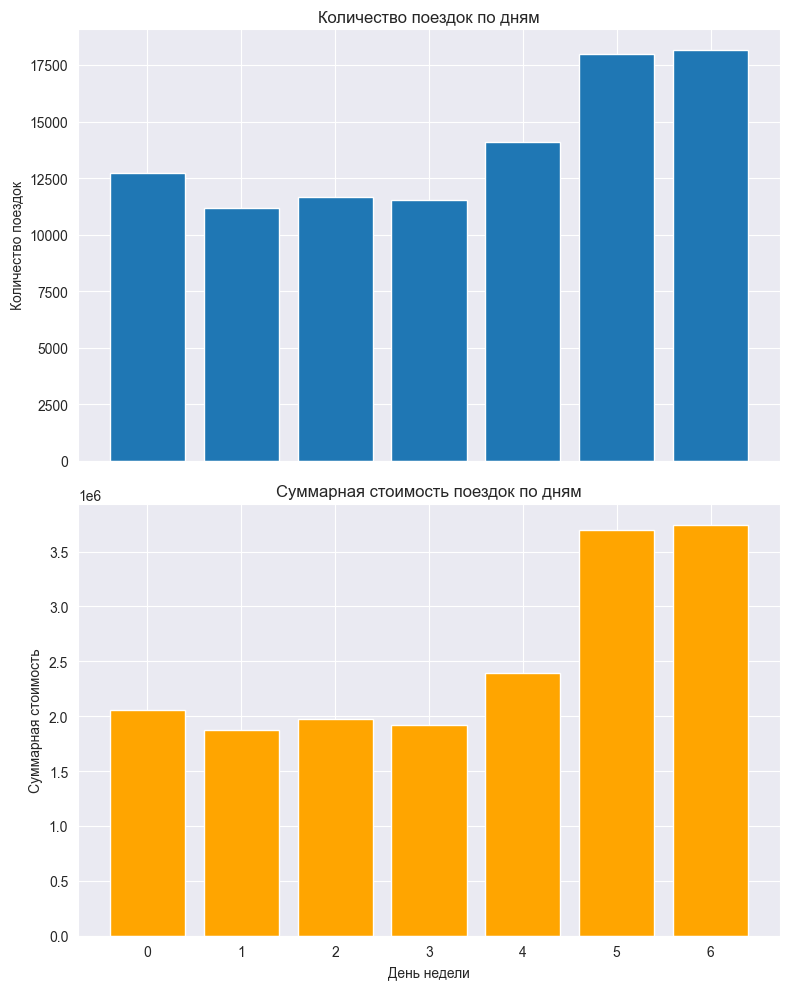

In [6]:
print("Средняя стоимость поездки:", round(df_rides['cost'].mean(), 2))
print("Медианная стоимость поездки:", df_rides['cost'].median())
print("Минимальня стоимость поездки:", df_rides['cost'].min())
print("Максимальная стоимость поездки:", df_rides['cost'].max())

df_temp = df_rides.copy()
df_temp['weekday'] = df_temp.apply(lambda x: x['start_date'].dayofweek, axis=1)

rides = df_temp.groupby('weekday').size().reset_index(name='rides_count')
rides_amount = df_temp.groupby('weekday')['cost'].sum().reset_index(name='rides_sum')
print(rides)

df_plot = rides.merge(rides_amount, on='weekday')

fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# 1-й график: количество поездок
axes[0].bar(df_plot['weekday'], df_plot['rides_count'])
axes[0].set_ylabel('Количество поездок')
axes[0].set_title('Количество поездок по дням')

# 2-й график: сумма стоимости
axes[1].bar(df_plot['weekday'], df_plot['rides_sum'], color='orange')
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Суммарная стоимость')
axes[1].set_title('Суммарная стоимость поездок по дням')

plt.tight_layout()
plt.show()

# Количество поездок по понедельникам с 6 до 10

Средняя стоимость поездки: 181.3
Медианная стоимость поездки: 170.0
Минимальня стоимость поездки: 24.0
Максимальная стоимость поездки: 625.0
   weekday  rides_count
0        0         2675
1        1         2152
2        2         2082
3        3         2164
4        4         2230
5        5         1178
6        6         1279


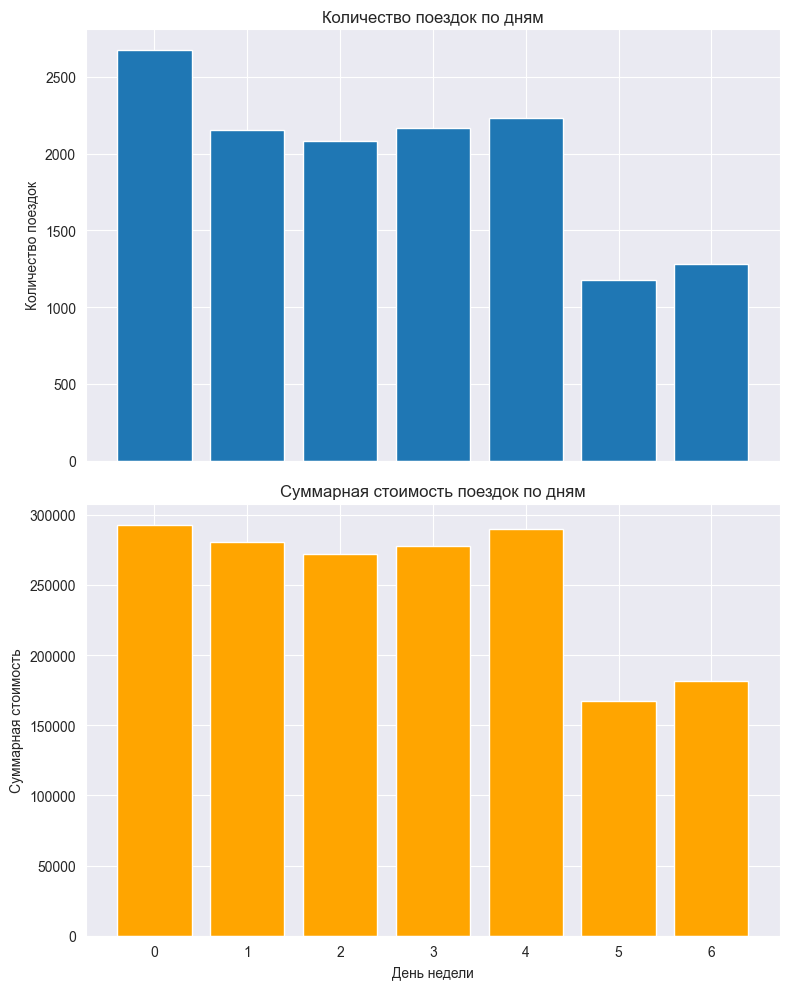

In [7]:
print("Средняя стоимость поездки:", round(df_rides['cost'].mean(), 2))
print("Медианная стоимость поездки:", df_rides['cost'].median())
print("Минимальня стоимость поездки:", df_rides['cost'].min())
print("Максимальная стоимость поездки:", df_rides['cost'].max())

df_temp = df_rides.copy()
df_temp['weekday'] = df_temp.apply(lambda x: x['start_date'].dayofweek, axis=1)

mask = (df_rides['start_date'].dt.time >= pd.Timestamp('06:00:00').time()) & \
       (df_rides['start_date'].dt.time <= pd.Timestamp('10:00:00').time())

rides = df_temp[mask].groupby('weekday').size().reset_index(name='rides_count')
rides_amount = df_temp[mask].groupby('weekday')['cost'].sum().reset_index(name='rides_sum')

print(rides)

df_plot = rides.merge(rides_amount, on='weekday')

fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# 1-й график: количество поездок
axes[0].bar(df_plot['weekday'], df_plot['rides_count'])
axes[0].set_ylabel('Количество поездок')
axes[0].set_title('Количество поездок по дням')

# 2-й график: сумма стоимости
axes[1].bar(df_plot['weekday'], df_plot['rides_sum'], color='orange')
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Суммарная стоимость')
axes[1].set_title('Суммарная стоимость поездок по дням')

plt.tight_layout()
plt.show()

# 2. Почасовой трафик

## Почасовой трафик в каждой точке

In [8]:
# создаем колонку с часом

rides_hours = df_rides.copy()
rides_hours['start_hour'] = rides_hours['start_date'].dt.floor('h')
rides_hours['end_hour'] = rides_hours['end_date'].dt.floor('h')

rides_hours.head(10)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,cost,start_hour,end_hour
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.000000,0,1422.0,126.0,2023-04-22 09:00:00,2023-04-22 09:00:00
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,Заречный,Спортивная,Октябрьский,4515.000000,0,1705.0,146.0,2023-04-22 09:00:00,2023-04-22 09:00:00
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,Ленинский,4520.000000,0,2299.0,186.0,2023-04-22 09:00:00,2023-04-22 09:00:00
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.000000,0,1909.0,158.0,2023-04-22 09:00:00,2023-04-22 09:00:00
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.000000,0,1840.0,154.0,2023-04-22 09:00:00,2023-04-22 09:00:00
5,100345,2023-04-22 09:10:09,2023-04-22 09:49:56,Лесная,Юго-Восточный,Западная,Ленинский,4879.000000,0,2387.0,190.0,2023-04-22 09:00:00,2023-04-22 09:00:00
6,100346,2023-04-22 09:15:12,2023-04-22 09:26:01,Пролетарская,Центральный,Свободы,Ленинский,1846.000000,0,649.0,74.0,2023-04-22 09:00:00,2023-04-22 09:00:00
7,100347,2023-04-22 09:19:13,2023-04-22 09:40:03,Комарова,Ленинский,Западная,Ленинский,3133.000000,0,1250.0,114.0,2023-04-22 09:00:00,2023-04-22 09:00:00
8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,Западная,Ленинский,Озерная,Юго-Восточный,2764.434176,0,1042.0,102.0,2023-04-22 09:00:00,2023-04-22 09:00:00
9,100349,2023-04-22 09:28:00,2023-04-22 10:02:08,Свободы,Ленинский,Чкалова,Юго-Восточный,5263.000000,0,2048.0,170.0,2023-04-22 09:00:00,2023-04-22 10:00:00


In [9]:
df_rides.to_csv('data/rides_calc.csv', index=False, date_format='%Y-%m-%d %H:%M:%S')
print("Файл rides_calc.csv успешно сохранен.")

Файл rides_calc.csv успешно сохранен.
